<a href="https://colab.research.google.com/github/jei-cm/Outlier_detection/blob/main/Proyecto_IA_OUTLIERS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detección de outliers
* Dataset tomado de: https://www.datos.gov.co/Agricultura-y-Desarrollo-RuralResultados-de-An-lisis-de-Laboratorio-Suelos-en-Co/ch4u-f3i5

* Integrantes: Juan Pablo Guerrero - Jeimmy Cuitiva Mont 


In [ ]:
import math
import sklearn
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

# metodos de detección de outliers
from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor

# **Preprocesamiento de datos:**
Se leen los datos del csv, el tratamiento que se le hace a los datos es cambiar todos los valores que dicen ND o No indica por NaNs. Una vez se hace esto, se completan todos los NaNs existentes, para las variables categoricas se llenan con el valor más repetido en cada característica, en el caso de las variables númericas, se rellenan con el promedio de los datos de cada caracteristicas.
Es importante resaltar que las variables categoricas se deben convertir a varibles númericas para poder hacer la detección  

In [ ]:
# Lectura de datos y cambio de Nans
data = pd.read_csv("Analisis_Suelos_Colombia.csv", sep=',', header=0, na_values= ["ND", "No indica", "NO INDICA", "No Indica", "no Indica", "no indica", "ERROR: #N/A"])
# Guardamos los datos en limpio para analisis posteriores
data_original = pd.read_csv("Analisis_Suelos_Colombia.csv", sep=',', header=0)
data

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (14,22,29,30,31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,numfila,Departamento,Municipio,Cultivo,Estado,Tiempo Establecimiento,Topografia,Drenaje,Riego,Fertilizantes aplicados,FechaAnalisis,"pH agua:suelo 2,5:1,0",Materia orgánica (MO) %,Fósforo (P) Bray II mg/kg,Azufre (S) Fosfato monocalcico mg/kg,Acidez (Al+H) KCL cmol(+)/kg,Aluminio (Al) intercambiable cmol(+)/kg,Calcio (Ca) intercambiable cmol(+)/kg,Magnesio (Mg) intercambiable cmol(+)/kg,Potasio (K) intercambiable cmol(+)/kg,Sodio (Na) intercambiable cmol(+)/kg,capacidad de intercambio cationico (CICE) suma de bases cmol(+)/kg,"Conductividad el‚ctrica (CE) relacion 2,5:1,0 dS/m",Hierro (Fe) disponible olsen mg/kg,Cobre (Cu) disponible mg/kg,Manganeso (Mn) disponible Olsen mg/kg,Zinc (Zn) disponible Olsen mg/kg,Boro (B) disponible mg/kg,Hierro (Fe) disponible doble cido mg/kg,Cobre (Cu) disponible doble acido mg/kg,Manganeso (Mn) disponible doble acido mg/kg,Zinc (Zn) disponible doble cido mg/kg,Secuencial
0,NaN,CUNDINAMARCA,FUNZA,Uchuva,POR ESTABLECER,NO APLICA,Ondulado,Bueno,NaN,NaN,NaN,5.66,9.706679,5.622298591549295,4.345549738219895,NaN,NaN,4.96569191,0.9788292099999999,0.20453417999999998,0.14592724999999998,6.294983,0.22351319999999997,184.118,"<1,00",2.8760000000000003,3.462,0.109442,NaN,NaN,NaN,NaN,NaN
1,NaN,CUNDINAMARCA,BITUIMA,Citricos,POR ESTABLECER,NO APLICA,Ondulado,Bueno,No cuenta con riego,NaN,NaN,8.08,3.417595,7.570467605633801,6.832460732984293,NaN,NaN,42.704796720000004,1.27535635,0.13121697599999999,0.12028233,44.231652,0.6927323999999999,33.181,3.426,"<1,00",90.92600000000002,0.710300,NaN,NaN,NaN,NaN,NaN
2,NaN,CUNDINAMARCA,VILLAPINZÓN,Pastos-brachiaria,ESTABLECIDO,NaN,Ondulado,Bueno,No cuenta con riego,NaN,NaN,5.87,2.336659,16.901171830985913,14.424083769633508,NaN,NaN,9.59718306,0.9457007199999999,0.194180868,0.13846343,10.875528,0.3344772,670.747,3.7199999999999998,8.481,2.455,0.130901,NaN,NaN,NaN,NaN,NaN
3,NaN,CUNDINAMARCA,VILLAPINZÓN,Pastos-brachiaria,ESTABLECIDO,NaN,Ondulado,Bueno,No cuenta con riego,NaN,NaN,5.56,6.853757,32.07638309859154,9.581151832460733,NaN,NaN,7.528300300000001,0.8416084699999999,1.5904150199999998,"<0,14",10.060324,0.3614256,791.175,6.83,5.694,2.6310000000000002,0.302575,NaN,NaN,NaN,NaN,NaN
4,NaN,CUNDINAMARCA,"BOGOTÁ, D.C.",Papa de año,POR ESTABLECER,NO APLICA,Pendiente,Bueno,No cuenta con riego,"15-15-15, 18-18-18 y 10-30-10",NaN,4.87,16.041251,64.19919999999999,5.523560209424084,5.028454,4.64315,2.23477545,0.34667245,0.31318768799999996,0.15635745999999998,8.079447,0.3741072,1685.377,4.124,17.619,8.567,0.302575,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46740,NaN,TOLIMA,ARMERO GUAYABAL,Neem,ESTABLECIDO,de 1 a 5 años,Plano,Buen drenaje,NaN,NaN,NaN,6.81,1.090000,68.6,5.94,NaN,NaN,13.7,3.7,0.7,0.23,18.330000,0.24,22.38,"<1,00","<1,00","<1,00",0.270000,NaN,NaN,NaN,NaN,NaN
46741,NaN,BOYACÁ,DUITAMA,Hortalizas,POR ESTABLECER,NO APLICA,Plano,Buen drenaje,NaN,NaN,NaN,7.16,0.960000,43.82,15.46,NaN,NaN,18.37,0.3,"<0,09",0.15,18.900000,0.92,58.14,"<1,00",1.79,5.5,0.170000,NaN,NaN,NaN,NaN,NaN
46742,NaN,CUNDINAMARCA,SASAIMA,Citricos-Limón,POR ESTABLECER,NO APLICA,Ondulado y Pendiente,Buen drenaje,NaN,NaN,NaN,4.19,4.610000,24.13,10.11,9.140000,8.29000,"<0,59","<0,20",0.17,"<0,14",9.650000,0.24,619.77,8.22,"<1,00",2.04,0.260000,NaN,NaN,NaN,NaN,NaN
46743,NaN,TOLIMA,HERVEO,Aguacate,NaN,NaN,Pendiente moderada,Buen drenaje,NaN,NaN,NaN,5.73,6.410000,5.34,10.25,NaN,NaN,2.29,0.42,0.12,"<0,14",2.910000,0.11,75.3,1.53,1.42,"<1,00",0.100000,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Se completan los NaNs categoricos con la moda de la caracteristica
data[["Riego"]] = data[["Riego"]].apply(lambda x: x.fillna(x.value_counts().index[0]))
data[["Estado"]] = data[["Estado"]].apply(lambda x: x.fillna(x.value_counts().index[0]))
data[["Cultivo"]] = data[["Cultivo"]].apply(lambda x: x.fillna(x.value_counts().index[0]))
data[["Drenaje"]] = data[["Drenaje"]].apply(lambda x: x.fillna(x.value_counts().index[0]))
data[["Topografia"]] = data[["Topografia"]].apply(lambda x: x.fillna(x.value_counts().index[0]))
data[["Tiempo Establecimiento"]] = data[["Tiempo Establecimiento"]].apply(lambda x: x.fillna(x.value_counts().index[0]))
data[["Fertilizantes aplicados"]] = data[["Fertilizantes aplicados"]].apply(lambda x: x.fillna(x.value_counts().index[0]))

for n in [11, 13, 14, 17, 18, 19, 20, 22, 23, 24, 25, 26, 29, 30, 31]: # se limpian los datos numericos, y se saturan los datos que representan intervalos 
  data[data.columns[n]] = data[data.columns[n]].astype(dtype="str")
  data[data.columns[n]] = data[data.columns[n]].map(lambda x: x.lstrip('<')) # <0,3 => 0,3
  data[data.columns[n]] = data[data.columns[n]].str.replace("MI","")
  data[data.columns[n]] = data[data.columns[n]].str.replace(",",".") # 0,001 => 0.001
  data[data.columns[n]] = pd.to_numeric(data[data.columns[n]], errors="coerce")

#se completan los NaNs numericos con la media de la caracteristica 
for n in range(11,32):
  data[data.columns[n]].fillna(value=data[data.columns[n]].mean(), inplace=True)

data = data.drop(["numfila" , "FechaAnalisis", "Secuencial"], axis=1) # se eliminan columnas vacias 

In [ ]:
data.to_csv("Dataset_tratado.csv") # Se guarda el dataset limpio 
data.info() # aquí podemos observar todas las caracteristicas completas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46745 entries, 0 to 46744
Data columns (total 30 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   Departamento                                                        46745 non-null  object 
 1   Municipio                                                           46745 non-null  object 
 2   Cultivo                                                             46745 non-null  object 
 3   Estado                                                              46745 non-null  object 
 4   Tiempo Establecimiento                                              46745 non-null  object 
 5   Topografia                                                          46745 non-null  object 
 6   Drenaje                                                             46745 non-null  object 
 7   Riego        

In [ ]:
# describe es una función para visualizar las clases existentes dentro de una característica
# esto se uso para ver si existian datos dentro de No indica, ND, etc. 
data.describe(include=["object"])

,Departamento,Municipio,Cultivo,Estado,Tiempo Establecimiento,Topografia,Drenaje,Riego,Fertilizantes aplicados
count,46745,46745,46745,46745,46745,46745,46745,46745,46745
unique,31,908,236,2,5,11,7,11,986
top,CUNDINAMARCA,VILLAVICENCIO,Cacao,ESTABLECIDO,NO APLICA,Plano,Bueno,No cuenta con riego,No ha aplicado fertilizantes
freq,9169,880,7941,30323,25781,20683,36541,39007,39190


In [ ]:
# describen las caracteristicas numericas para observar sus estadisticas 
data.describe(include=["float64"])

,"pH agua:suelo 2,5:1,0",Materia orgánica (MO) %,Fósforo (P) Bray II mg/kg,Azufre (S) Fosfato monocalcico mg/kg,Acidez (Al+H) KCL cmol(+)/kg,Aluminio (Al) intercambiable cmol(+)/kg,Calcio (Ca) intercambiable cmol(+)/kg,Magnesio (Mg) intercambiable cmol(+)/kg,Potasio (K) intercambiable cmol(+)/kg,Sodio (Na) intercambiable cmol(+)/kg,capacidad de intercambio cationico (CICE) suma de bases cmol(+)/kg,"Conductividad el‚ctrica (CE) relacion 2,5:1,0 dS/m",Hierro (Fe) disponible olsen mg/kg,Cobre (Cu) disponible mg/kg,Manganeso (Mn) disponible Olsen mg/kg,Zinc (Zn) disponible Olsen mg/kg,Boro (B) disponible mg/kg,Hierro (Fe) disponible doble cido mg/kg,Cobre (Cu) disponible doble acido mg/kg,Manganeso (Mn) disponible doble acido mg/kg,Zinc (Zn) disponible doble cido mg/kg
count,46745.000000,46745.000000,46745.000000,46745.000000,46745.000000,46745.000000,46745.000000,46745.000000,46745.000000,46745.000000,46745.000000,46745.000000,46745.000000,46745.000000,46745.000000,46745.000000,46745.000000,46745.000000,46745.000000,46745.000000,46745.000000
mean,5.685422,5.065328,34.364728,13.784466,2.085799,1.649642,6.905377,2.184502,0.396901,0.200660,10.685826,0.442381,287.282955,3.443558,7.965979,4.460861,0.273698,64.963030,1.372805,11.609078,2.719156
std,0.923248,5.087316,80.927758,51.884707,1.392647,1.187653,7.779912,2.751451,0.687893,0.471936,9.367072,1.115211,393.466767,4.600688,16.388550,12.620983,0.334966,15.658626,0.185824,3.943155,1.325600
min,3.440000,-0.100000,0.088036,0.010000,0.000000,0.000000,0.028436,0.006155,0.005064,0.000000,0.196087,0.010000,0.100000,0.036000,0.112000,0.020000,0.005751,1.240000,0.160000,0.080000,0.040000
25%,5.000000,1.925183,3.870000,3.787938,1.625810,1.240000,1.636310,0.458911,0.129139,0.087040,4.436576,0.155350,62.430000,1.300000,2.235597,1.000000,0.127581,64.963030,1.372805,11.609078,2.719156
50%,5.520000,3.210077,9.004298,6.197227,2.085799,1.649642,4.471007,1.171920,0.245722,0.140000,7.744804,0.237350,162.461538,2.447000,4.570000,1.814070,0.203431,64.963030,1.372805,11.609078,2.719156
75%,6.220000,6.181102,30.023883,11.273698,2.085799,1.649642,9.451492,2.686958,0.476800,0.160795,13.873440,0.414100,353.474000,3.984000,8.000000,4.460861,0.323507,64.963030,1.372805,11.609078,2.719156
max,10.260000,68.089436,3015.628330,4862.835570,28.306478,25.812844,137.179860,30.658517,88.251964,35.937241,140.279152,88.118098,7972.920000,221.153925,883.370000,708.644000,27.843566,1263.212800,9.852000,208.800000,98.000000


In [ ]:
data["Departamento"].value_counts()

CUNDINAMARCA          9169
VALLE DEL CAUCA       8110
ANTIOQUIA             3500
META                  3184
BOYACÁ                2905
NARIÑO                2411
NORTE DE SANTANDER    2082
SANTANDER             1698
CÓRDOBA               1620
TOLIMA                1616
BOLÍVAR               1390
CAUCA                 1285
PUTUMAYO              1013
CESAR                 1001
CAQUETÁ                882
CASANARE               814
HUILA                  806
MAGDALENA              611
LA GUAJIRA             579
SUCRE                  431
ATLÁNTICO              413
CALDAS                 331
GUAVIARE               266
RISARALDA              181
ARAUCA                 167
VICHADA                 99
QUINDIO                 73
AMAZONAS                53
GUAINÍA                 20
CHOCÓ                   19
BOGOTÁ, D.C.            16
Name: Departamento, dtype: int64

In [ ]:
data["Municipio"].value_counts()

VILLAVICENCIO           880
CÚCUTA                  856
PALMIRA                 782
RIONEGRO                712
CERETÉ                  629
                       ... 
ENCISO                    1
HATO                      1
AMBALEMA                  1
SAN LUIS DE CUBARRAL      1
CHÁMEZA                   1
Name: Municipio, Length: 908, dtype: int64

In [ ]:
data["Cultivo"].value_counts()

Cacao                                       7941
Pastos                                      5527
Aguacate                                    3866
Caña panelera/azucar                        2216
Café                                        2164
                                            ... 
Caña/forrajera                                 1
Forestal-Flor morado                           1
Zapote                                         1
Aromaticas-Cidron                              1
flores Ornamentales-Flor ave del paraiso       1
Name: Cultivo, Length: 236, dtype: int64

In [ ]:
data["Estado"].value_counts()

ESTABLECIDO       30323
POR ESTABLECER    16422
Name: Estado, dtype: int64

In [ ]:
data["Tiempo Establecimiento"].value_counts()

NO APLICA         25781
de 1 a 5 años      8403
de 0 a 1 año       4974
mas de 10 años     3984
de 5 a 10 años     3603
Name: Tiempo Establecimiento, dtype: int64

In [ ]:
data["Topografia"].value_counts()

Plano                     20683
Ondulado                  10980
Pendiente                 10187
Moderadamente ondulado     2262
Pendiente moderada         2124
Ligeramente ondulado        271
Pendiente leve              101
Ondulado y Pendiente         65
Pendiente fuerte             30
Plano y ondulado             29
Plano y pendiente            13
Name: Topografia, dtype: int64

In [ ]:
data["Drenaje"].value_counts()

Bueno               36541
Regular              6788
Buen drenaje         1762
Regular drenaje       834
Malo                  757
Mal drenaje            61
Muy buen drenaje        2
Name: Drenaje, dtype: int64

In [ ]:
data["Riego"].value_counts()

No cuenta con riego     39007
Aspersión                2761
Gravedad                 2231
Goteo                    2010
Manguera                  573
Aspersión y Goteo          61
Por Inundación             46
Cañón                      36
Goteo y Gravedad            8
Aspersión y Gravedad        7
Microaspersión              5
Name: Riego, dtype: int64

In [ ]:
data["Fertilizantes aplicados"].value_counts()

No ha aplicado fertilizantes             39190
15-15-15                                   875
Abono orgánico                             610
Urea                                       463
17-6-18-2                                  271
                                         ...  
15-15-15, Nitrato de calcio y Menores        1
10-30-10 y Boro                              1
26-4-4                                       1
35-10-5 y Urea                               1
KCl y Cal dolomita                           1
Name: Fertilizantes aplicados, Length: 986, dtype: int64

In [ ]:
# Variables categoricas se cambian a númericas usando OrdinalEncoder
categorical = ["Departamento","Municipio","Cultivo","Estado","Tiempo Establecimiento","Topografia","Drenaje","Riego","Fertilizantes aplicados"]
enc = OrdinalEncoder()
enc.fit(data[categorical])
data[categorical] = enc.transform(data[categorical])
data[categorical].head()

,Departamento,Municipio,Cultivo,Estado,Tiempo Establecimiento,Topografia,Drenaje,Riego,Fertilizantes aplicados
0,13.0,291.0,208.0,1.0,0.0,2.0,1.0,9.0,845.0
1,13.0,83.0,69.0,1.0,0.0,2.0,1.0,9.0,845.0
2,13.0,877.0,181.0,0.0,0.0,2.0,1.0,9.0,845.0
3,13.0,877.0,181.0,0.0,0.0,2.0,1.0,9.0,845.0
4,13.0,86.0,158.0,1.0,0.0,4.0,1.0,9.0,253.0


In [ ]:
# Se eliminan características que no se necesitan 
quitar = ["Departamento", "Municipio", "Fertilizantes aplicados"]
data = data.drop(quitar, axis=1)
data.head()

,Cultivo,Estado,Tiempo Establecimiento,Topografia,Drenaje,Riego,"pH agua:suelo 2,5:1,0",Materia orgánica (MO) %,Fósforo (P) Bray II mg/kg,Azufre (S) Fosfato monocalcico mg/kg,Acidez (Al+H) KCL cmol(+)/kg,Aluminio (Al) intercambiable cmol(+)/kg,Calcio (Ca) intercambiable cmol(+)/kg,Magnesio (Mg) intercambiable cmol(+)/kg,Potasio (K) intercambiable cmol(+)/kg,Sodio (Na) intercambiable cmol(+)/kg,capacidad de intercambio cationico (CICE) suma de bases cmol(+)/kg,"Conductividad el‚ctrica (CE) relacion 2,5:1,0 dS/m",Hierro (Fe) disponible olsen mg/kg,Cobre (Cu) disponible mg/kg,Manganeso (Mn) disponible Olsen mg/kg,Zinc (Zn) disponible Olsen mg/kg,Boro (B) disponible mg/kg,Hierro (Fe) disponible doble cido mg/kg,Cobre (Cu) disponible doble acido mg/kg,Manganeso (Mn) disponible doble acido mg/kg,Zinc (Zn) disponible doble cido mg/kg
0,208.0,1.0,0.0,2.0,1.0,9.0,5.66,9.706679,5.622299,4.345550,2.085799,1.649642,4.965692,0.978829,0.204534,0.145927,6.294983,0.223513,184.118,1.000,2.876,3.462,0.109442,64.96303,1.372805,11.609078,2.719156
1,69.0,1.0,0.0,2.0,1.0,9.0,8.08,3.417595,7.570468,6.832461,2.085799,1.649642,42.704797,1.275356,0.131217,0.120282,44.231652,0.692732,33.181,3.426,1.000,90.926,0.710300,64.96303,1.372805,11.609078,2.719156
2,181.0,0.0,0.0,2.0,1.0,9.0,5.87,2.336659,16.901172,14.424084,2.085799,1.649642,9.597183,0.945701,0.194181,0.138463,10.875528,0.334477,670.747,3.720,8.481,2.455,0.130901,64.96303,1.372805,11.609078,2.719156
3,181.0,0.0,0.0,2.0,1.0,9.0,5.56,6.853757,32.076383,9.581152,2.085799,1.649642,7.528300,0.841608,1.590415,0.140000,10.060324,0.361426,791.175,6.830,5.694,2.631,0.302575,64.96303,1.372805,11.609078,2.719156
4,158.0,1.0,0.0,4.0,1.0,9.0,4.87,16.041251,64.199200,5.523560,5.028454,4.643150,2.234775,0.346672,0.313188,0.156357,8.079447,0.374107,1685.377,4.124,17.619,8.567,0.302575,64.96303,1.372805,11.609078,2.719156


In [ ]:
# Se escalizan los datos
scaler = StandardScaler()
data_sc = scaler.fit_transform(data) 
print(data_sc.shape)

(46745, 27)


In [ ]:
# PCA
N = data_sc.shape[1]
pca = PCA(n_components=N, whiten=True).fit(data_sc)
data_pca = pca.transform(data_sc)
print("Pesos de PCA:",pca.explained_variance_ratio_)
print("Suma de pesos: ", sum(pca.explained_variance_ratio_))

Pesos de PCA: [1.48152816e-01 8.82879664e-02 7.67564673e-02 6.29159857e-02
 5.96546139e-02 4.92375398e-02 4.48494587e-02 4.26817208e-02
 4.01682424e-02 3.73370590e-02 3.50648214e-02 3.38696506e-02
 3.13686132e-02 3.02251006e-02 2.75343330e-02 2.69005040e-02
 2.58222855e-02 2.39136135e-02 2.21351577e-02 2.14360856e-02
 1.88855857e-02 1.67599779e-02 1.51360871e-02 1.18221389e-02
 8.51083446e-03 4.71102952e-04 1.02238471e-04]
Suma de pesos:  1.0000000000000002


# DETECCIÓN DE OUTLIERS

1.   Sin PCA


In [ ]:
# Detección usando Elliptic Envelope

MCD = EllipticEnvelope(store_precision=True, assume_centered=True, support_fraction=0.99, contamination=0.1, random_state=10)
y_pred = MCD.fit_predict(data_sc)

idx_MCD = np.where(y_pred==-1)[0]
outlier_values_MCD = data_original.iloc[idx_MCD].copy()

In [ ]:
outlier_values_MCD.to_csv("outliers_MCD_.csv", sep=';')
print("Número de Outliers detectados con MCD: ", len(outlier_values_MCD))
detect_outliers = []
detect_outliers.append(("MCD", len(outlier_values_MCD)))

Número de Outliers detectados con MCD:  4675


In [ ]:
# Detección usando Isolation Forest 

forest = IsolationForest(n_estimators=30, warm_start=True)
y_predictf = forest.fit_predict(data_sc)

idx_if = np.where(y_predictf==-1)[0]
outlier_values_if = data_original.iloc[idx_if]

In [ ]:
outlier_values_if.to_csv("outliers_IF_.csv", sep=';')
print("Número de Outliers detectados con IF: ", len(outlier_values_if))
detect_outliers.append(("IF", len(outlier_values_if)))

Número de Outliers detectados con IF:  1986


In [ ]:
# Detección Local Outlier Factor(LOF)

LOF = LocalOutlierFactor(n_neighbors=10)
y_predlof = LOF.fit_predict(data_sc)

idx_LOF = np.where(y_predlof==-1)[0]
outlier_values_lof = data_original.iloc[idx_LOF]

In [ ]:
outlier_values_lof.to_csv("outliers_LOF_.csv", sep=';')
print("Número de Outliers detectados con LOF: ", len(outlier_values_lof))
detect_outliers.append(("LOF", len(outlier_values_lof)))

Número de Outliers detectados con LOF:  1908


In [ ]:
# Detección SVM
SVM = svm.OneClassSVM()
y_predsvm = SVM.fit_predict(data_sc)

idx_SVM = np.where(y_predsvm==-1)[0]
outlier_values_svm = data_original.iloc[idx_SVM]

In [ ]:
outlier_values_svm.to_csv("outliers_SVM_.csv", sep=';')
print("Número de Outliers detectados con SVM: ", len(outlier_values_svm))
detect_outliers.append(("SVM", len(outlier_values_svm)))

Número de Outliers detectados con SVM:  23375


2. Con PCA 

In [ ]:
# Detección usando Elliptic Envelope con PCA
MCD_PCA = EllipticEnvelope(store_precision=True, assume_centered=True, support_fraction=0.99, contamination=0.1, random_state=10)
y_predpca = MCD_PCA.fit_predict(data_pca)

idx_MCD_PCA = np.where(y_predpca==-1)[0]
outlier_values_MCD_pca = data_original.iloc[idx_MCD_PCA].copy()

In [ ]:
outlier_values_MCD_pca.to_csv("outliers_MCD_PCA.csv", sep=';')
print("Número de Outliers detectados con MCD y PCA: ", len(outlier_values_MCD_pca))
detect_outliers.append(("MCD_PCA", len(outlier_values_MCD_pca)))

Número de Outliers detectados con MCD y PCA:  4675


In [ ]:
# Detección usando Isolation Forest con PCA
forest_pca = IsolationForest(n_estimators=30, warm_start=True)
y_predict_f_pca = forest_pca.fit_predict(data_pca)

idx_if_PCA = np.where(y_predict_f_pca==-1)[0]
outlier_values_if_pca = data_original.iloc[idx_if_PCA]

In [ ]:
outlier_values_if_pca.to_csv("outliers_IF_PCA.csv")
print("Número de Outliers detectados con IF y PCA: ", len(outlier_values_if_pca))
detect_outliers.append(("IF_PCA", len(outlier_values_if_pca)))

Número de Outliers detectados con IF y PCA:  1934


In [ ]:
# Detección Local Outlier Factor(LOF) PCA 
LOF_PCA = LocalOutlierFactor(n_neighbors=10)
y_predlof_pca = LOF_PCA.fit_predict(data_pca)

idx_LOF_PCA = np.where(y_predlof_pca==-1)[0]
outlier_values_lof_pca = data_original.iloc[idx_LOF_PCA]

In [ ]:
outlier_values_lof_pca.to_csv("outliers_LOF_PCA.csv")
print("Número de Outliers detectados con LOF y PCA: ", len(outlier_values_lof_pca))
detect_outliers.append(("LOF_PCA", len(outlier_values_lof_pca)))

Número de Outliers detectados con LOF y PCA:  2611


In [ ]:
# Detección SVM con PCA
SVM_PCA = svm.OneClassSVM()
y_predsvm_pca = SVM_PCA.fit_predict(data_pca)

idx_SVM_PCA = np.where(y_predsvm_pca==-1)[0]
outlier_values_svm_pca = data_original.iloc[idx_SVM_PCA]

In [ ]:
outlier_values_svm_pca.to_csv("outliers_SVM_PCA.csv")
print("Número de Outliers detectados con SVM y PCA: ", len(outlier_values_svm_pca))
detect_outliers.append(("SVM_PCA", len(outlier_values_svm_pca)))

Número de Outliers detectados con SVM y PCA:  23371


# Análisis

* Las siguientes graficas muestran el número de outliers detectados en cada clase encontrada dentro de "Fertilizantes aplicados", con la finalidad de comprobar si existe alguna correlación entre los outliers contra esta característica. 

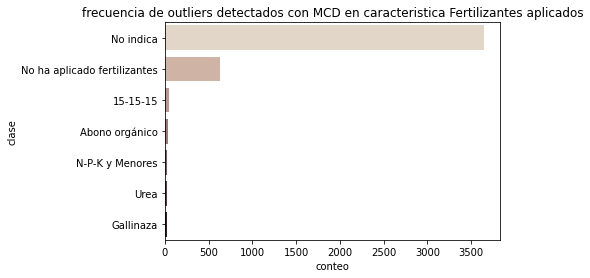

In [ ]:
import seaborn as sns

outlier_fertilizantes_MCD = data_original["Fertilizantes aplicados"].iloc[idx_MCD].value_counts().rename_axis('clase').reset_index(name='conteo')

plt.title("frecuencia de outliers detectados con MCD en caracteristica Fertilizantes aplicados")
sns.barplot(x="conteo", y="clase", palette="ch:.25", data=outlier_fertilizantes_MCD.iloc[0:7])

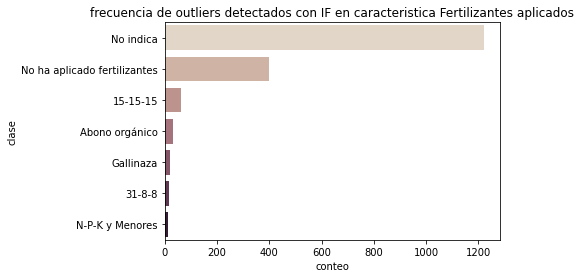

In [ ]:
outlier_fertilizantes_IF = data_original["Fertilizantes aplicados"].iloc[idx_if].value_counts().rename_axis('clase').reset_index(name='conteo')

plt.title("frecuencia de outliers detectados con IF en caracteristica Fertilizantes aplicados")
sns.barplot(x="conteo", y="clase", palette="ch:.25", data=outlier_fertilizantes_IF.iloc[0:7])

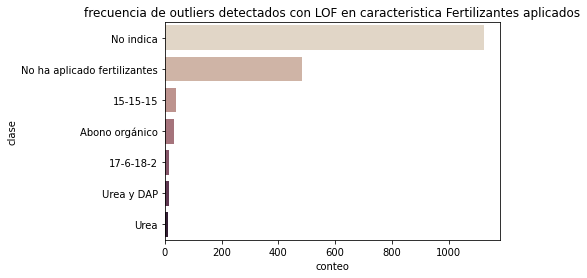

In [ ]:
outlier_fertilizantes_LOF = data_original["Fertilizantes aplicados"].iloc[idx_LOF].value_counts().rename_axis('clase').reset_index(name='conteo')

plt.title("frecuencia de outliers detectados con LOF en caracteristica Fertilizantes aplicados")
sns.barplot(x="conteo", y="clase",  palette="ch:.25", data=outlier_fertilizantes_LOF.iloc[0:7])

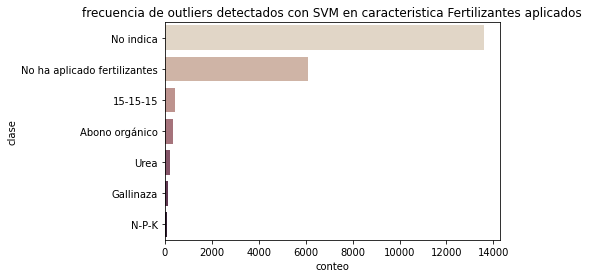

In [ ]:
outlier_fertilizantes_SVM = data_original["Fertilizantes aplicados"].iloc[idx_SVM].value_counts().rename_axis('clase').reset_index(name='conteo')

plt.title("frecuencia de outliers detectados con SVM en caracteristica Fertilizantes aplicados")
sns.barplot(x="conteo", y="clase", palette="ch:.25", data=outlier_fertilizantes_SVM.iloc[0:7])

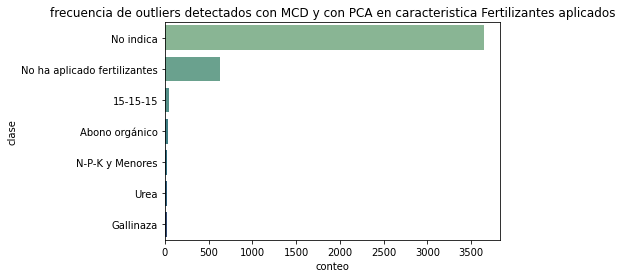

In [ ]:
outlier_fertilizantes_MCD_PCA = data_original["Fertilizantes aplicados"].iloc[idx_MCD_PCA].value_counts().rename_axis('clase').reset_index(name='conteo')

plt.title("frecuencia de outliers detectados con MCD y con PCA en caracteristica Fertilizantes aplicados")
sns.barplot(x="conteo", y="clase", palette="crest", data=outlier_fertilizantes_MCD_PCA.iloc[0:7])

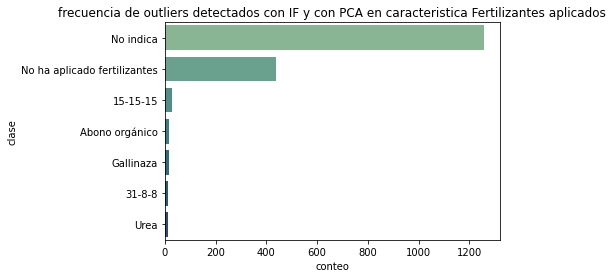

In [ ]:
outlier_fertilizantes_IF_PCA = data_original["Fertilizantes aplicados"].iloc[idx_if_PCA].value_counts().rename_axis('clase').reset_index(name='conteo')

plt.title("frecuencia de outliers detectados con IF y con PCA en caracteristica Fertilizantes aplicados")
sns.barplot(x="conteo", y="clase", palette="crest", data=outlier_fertilizantes_IF_PCA.iloc[0:7])

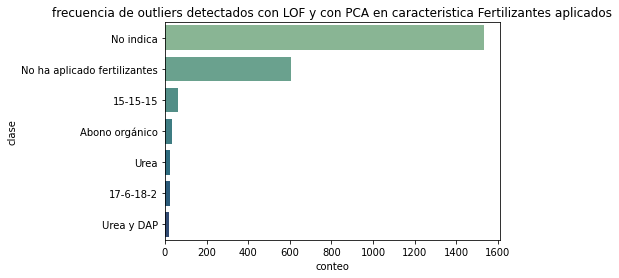

In [ ]:
outlier_fertilizantes_LOF_PCA = data_original["Fertilizantes aplicados"].iloc[idx_LOF_PCA].value_counts().rename_axis('clase').reset_index(name='conteo')

plt.title("frecuencia de outliers detectados con LOF y con PCA en caracteristica Fertilizantes aplicados")
sns.barplot(x="conteo", y="clase", palette="crest", data=outlier_fertilizantes_LOF_PCA.iloc[0:7])

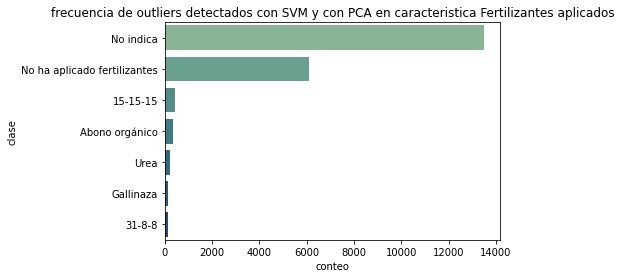

In [ ]:
outlier_fertilizantes_SVM_PCA = data_original["Fertilizantes aplicados"].iloc[idx_SVM_PCA].value_counts().rename_axis('clase').reset_index(name='conteo')

plt.title("frecuencia de outliers detectados con SVM y con PCA en caracteristica Fertilizantes aplicados")
sns.barplot(x="conteo", y="clase", palette="crest", data=outlier_fertilizantes_SVM_PCA.iloc[0:7])

* Se hace una gráfica de barras para mostrar el número de outliers que se detectaron en cada método tanto usando PCA, como sin usar PCA

['MCD', 'IF', 'LOF', 'SVM', 'MCD_PCA', 'IF_PCA', 'LOF_PCA', 'SVM_PCA']
[4675, 1986, 1908, 23375, 4675, 1934, 2611, 23371]


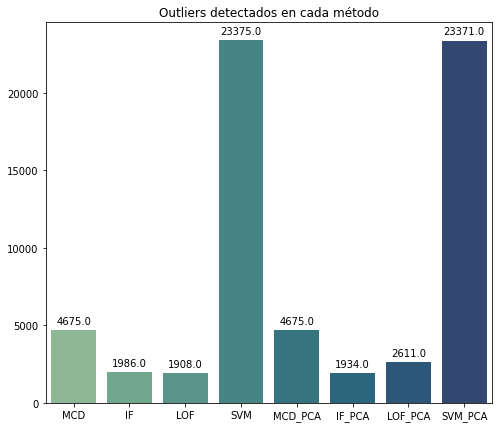

In [ ]:
met = [n[0] for n in detect_outliers]
print(x)
outliers = [n[1] for n in detect_outliers]
print(y)
plt.figure(figsize=(8,7))
plt.title("Outliers detectados en cada método")
splot = sns.barplot(x=met, y=outliers, palette="crest")
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')